**Importing the Necessary Libraries**

In [165]:
import glob
import numpy as np
import matplotlib.pyplot as plt

**Loading the Colored Images**

In [166]:
Col_Img = glob.glob("apples/*.jpg") 

ColorImgs = [] 
for myFile in Col_Img:
    im = plt.imread(myFile)
    im = im/255
    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorImgs.append(im) 

ColorImgs2 = []
Extra_Img = glob.glob("D_apples/*.jpg") 
for myFile in Extra_Img:
    im = plt.imread(myFile)
    im = im/255
    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorImgs2.append(im)
Extra_Img = glob.glob("D2_apples/*.jpg") 
for myFile in Extra_Img:
    im = plt.imread(myFile)
    im = im/255
    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    ColorImgs2.append(im)


**Loading the Image Masks**

In [167]:
MaskImage = glob.glob("apples/*.png") 

MaskImgs = [] 
for myFile in MaskImage:
    im = plt.imread(myFile) 
    # These mask-images are often 3-channel, and contain grayscale values. 
    # We would prefer 1-channel and just binary:
    im = im[:,:,1] 
    MaskImgs.append(im) 

Extramaks =  glob.glob("D_apples/*.png") 
MaskImgs2 = []
for myFile in Extramaks:
    im = plt.imread(myFile) 
    # These mask-images are often 3-channel, and contain grayscale values. 
    # We would prefer 1-channel and just binary:
    im = im[:,:,1] 
    MaskImgs2.append(im) 


Extramaks =  glob.glob("D2_apples/*.png") 
for myFile in Extramaks:
    im = plt.imread(myFile) 
    # These mask-images are often 3-channel, and contain grayscale values. 
    # We would prefer 1-channel and just binary:
    im = im[:,:,1] 
    MaskImgs2.append(im) 


**Displaying the Test Image and the Ground Truth Mask Images**

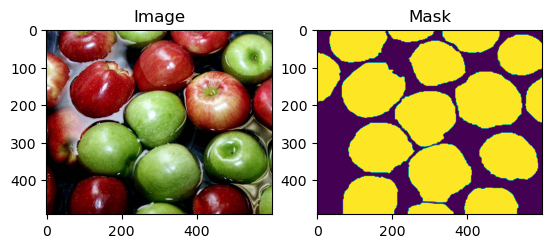

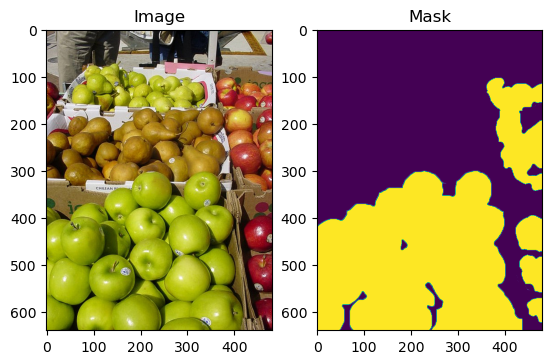

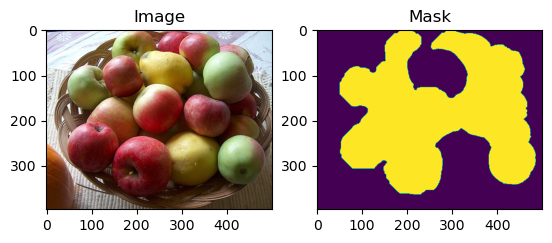

In [168]:
# display the test image and the ground truth mask
for i in range(len(ColorImgs)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ColorImgs[i])
    ax1.set_title('Image')
    ax2.imshow(MaskImgs[i])
    ax2.set_title('Mask')

***The training set includes the colored images and the masked images of the apples.***

***We want to count how many pixels belong to apples.***

In [169]:
nonApple = []
Apple = []
counterApple = 0
counterNonApple = 0
for i in range(len(ColorImgs)):
    for row in range(MaskImgs[i].shape[0]):
        for col in range(MaskImgs[i].shape[1]):
            # test if the pixel is black
            if(MaskImgs[i][row,col]==0):
                nonApple.append(ColorImgs[i][row,col,:])
                counterNonApple += 1
            else:
                Apple.append(ColorImgs[i][row,col,:])
                counterApple += 1
           
Apples = np.array(Apple).T  
nonApples = np.array(nonApple).T 



***Method for calculating Multi-dimensional Gaussian function:
Returns the probability of each data point belongong to a multivariate gaussian distribution.***

In [170]:
#Code from TO DO: B of practicalMixGaussA.ipynb lab
#the goal of this routine is to evaluate a Gaussian likelihood 
def calcGaussianProb(data,mean,cov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    #like = multivariate_normal.pdf(x=data.T, mean=mean, cov=cov)
    d = len(mean)
    mean = np.expand_dims(mean, axis=1)
    data_minus_mean = data - mean

    like = np.double(np.double(1/np.power(np.power(2*np.pi, d)*np.linalg.det(cov), 0.5)) * np.double(np.exp((-0.5) * np.sum((data_minus_mean.T @ np.linalg.pinv(cov)) * data_minus_mean.T, axis=1)))  )
    return like

***Calculating the likelihood of the pixels by combining the likelihoods from different Gaussian models together using weighted sum method.***

In [171]:
def getMixGaussLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.
    Returns:
    Like -- n by 1 matrix
    """
    # initialize ikelihoods                                                                       
    Like = np.zeros((data.shape[1], ))                                                                               
    for k in range(mixGaussEst['k']):
        prob = calcGaussianProb(data, mixGaussEst['mean'][:,k], mixGaussEst['cov'][:,:,k]) 
        Like += mixGaussEst['weight'][k] * prob  
    return  Like                                                               
                                  

***Training the mixture of Gaussian model. The algorithm tests the variance and checks if one of the covariances is larger than a specified threshold, (this usually results due to one gaussian trying to fit to much data). If this codition is met the covariance will reinitialize. Noise was added to improove the generalisation of the model. The weights are related to how well the model performed to classify a given pixel. The values of k relates to the number of gaussians used (hyperparameter), too low of a value can cause the model to underfit, whilst a value of of k that is too large might cause the model to overfit the data**

In [172]:
#Code from TO Do: G of practicalMixGaussB.ipynb lab
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    nDims, nData = data.shape

    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    nIter = 50
    
    for cIter in range(nIter):
        print('%d iter'%(cIter))

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        # Calculate posterior probability of the each pixel
        # R_ik
        for i in range(mixGaussEst['k']):
            postHidden[i] = mixGaussEst['weight'][i]*calcGaussianProb(data,mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i])
        
        postHidden = postHidden / np.sum(postHidden, axis=0)
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        for cGauss in range(k):

            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden)            

            mixGaussEst['mean'][:,cGauss] = (postHidden[cGauss,:].reshape(1,nData) @ np.transpose(data))/ np.sum(postHidden[cGauss,:])
            
            dataMinusMu = data - np.expand_dims(mixGaussEst['mean'][:,cGauss], axis=1)
            sumDist = postHidden[cGauss]*dataMinusMu@dataMinusMu.T
        
            # Normalize
            mixGaussEst['cov'][:,:,cGauss] = sumDist / np.sum(postHidden[cGauss,:]) 
        
            # check for the balance in the gaussian mixture
            if cGauss > 0:
                for index in range(cGauss):
                    for row in range(mixGaussEst['cov'][:,:,index].shape[0]):
                        for col in range(mixGaussEst['cov'][:,:,index].shape[1]):
                            
                            if mixGaussEst['cov'][row,col,index] / mixGaussEst['cov'][row,col,cGauss]>300 :
                                    
                                    
                                    mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*0.9
                                    mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*1.1
                                    if mixGaussEst['cov'][row,col,cGauss] <= 0.001:
                                        mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*5
                                  
                            if mixGaussEst['cov'][row,col,cGauss] / mixGaussEst['cov'][row,col,index] > 300:
                                    mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*0.9
                                    mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*1.1
                                    if mixGaussEst['cov'][row,col,index] <= 0.0005: 
                                        mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*5                                   

                                                           
    return mixGaussEst

***Training the mixture of Gaussians model for both apple and non-apple pixels***

In [173]:
#define number of components to estimate
nGaussEst = 3
#fit mixture of Gaussians 
appleMixGaussEst = fitMixGauss(Apples,nGaussEst);
nonAppleMixGaussEst = fitMixGauss(nonApples,nGaussEst);

0 iter
1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter
10 iter
11 iter
12 iter
13 iter
14 iter
15 iter
16 iter
17 iter
18 iter
19 iter
20 iter
21 iter
22 iter
23 iter
24 iter
25 iter
26 iter
27 iter
28 iter
29 iter
30 iter
31 iter
32 iter
33 iter
34 iter
35 iter
36 iter
37 iter
38 iter
39 iter
40 iter
41 iter
42 iter
43 iter
44 iter
45 iter
46 iter
47 iter
48 iter
49 iter
0 iter
1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter
10 iter
11 iter
12 iter
13 iter
14 iter
15 iter
16 iter
17 iter
18 iter
19 iter
20 iter
21 iter
22 iter
23 iter
24 iter
25 iter
26 iter
27 iter
28 iter
29 iter
30 iter
31 iter
32 iter
33 iter
34 iter
35 iter
36 iter
37 iter
38 iter
39 iter
40 iter
41 iter
42 iter
43 iter
44 iter
45 iter
46 iter
47 iter
48 iter
49 iter


***Loading the Test Images***

In [174]:
testImage = glob.glob("testApples/*.jpg") 
testImgs = [] 
for myFile in testImage:     
    im = plt.imread(myFile)
    im = im/255
    # Current image is now a double-precision 3D matrix of size (width x height x 3). 
    # Each of the 3 color channels is now in the range [0.0, 1.0].
    testImgs.append(im) 



***Calculating the posterior for each pixel of the test image.***

In [175]:
def CalculatePosterior(testImgs,priorApple):
    # let's define priors for whether the pixel is apple or non apple
    #priorApple = 0.6
    priorNonApple = 1 - priorApple
    posteriorApple = []
    for i in range(len(testImgs)):
        # now run through the pixels in the image and classify them as being apple or non apple 
        im = testImgs[i]
        imY, imX, imZ = im.shape

        im = np.double(im)
        im = np.transpose(im, [2, 0, 1])
        im = np.reshape(im, [im.shape[0], im.shape[1]*im.shape[2]]) 
        likeApple = getMixGaussLike(im,appleMixGaussEst)
        likeNonApple = getMixGaussLike(im,nonAppleMixGaussEst)
        posterior = (likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)
        posterior = np.reshape(posterior, (imY, imX))
        posteriorApple.append(posterior)

    return posteriorApple

***Calculating the Prior. The prior is calculated by taking all the pixels belonging the the apple and normlizing them to the overall image***
***Calculate the posterior of the test set, by using the values for prior and ikelihood obtained from the segmented data***

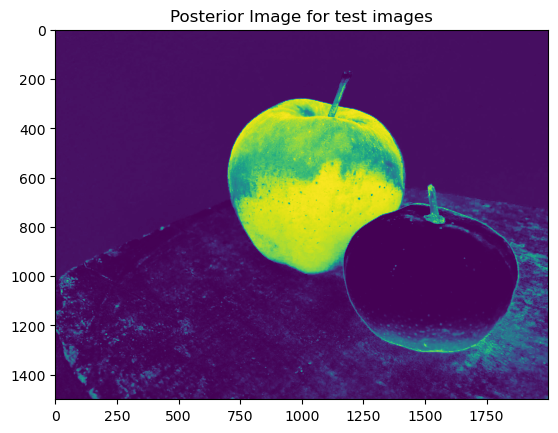

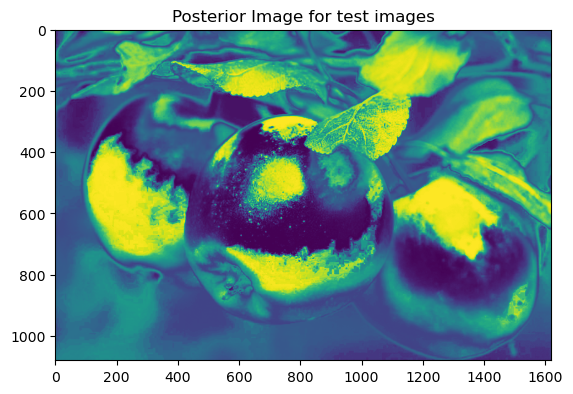

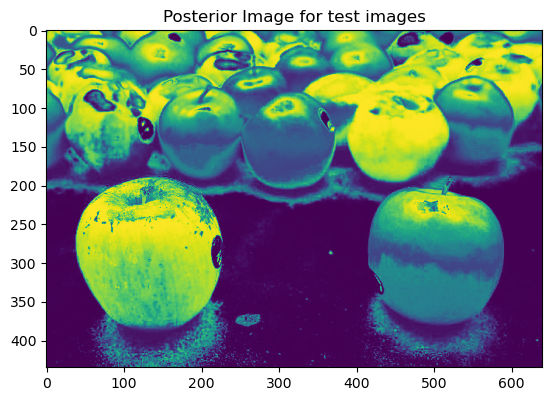

In [176]:
priorApple = counterApple/(counterApple+counterNonApple)
# posterior
posteriorApple = CalculatePosterior(testImgs,priorApple)
for i in range(len(posteriorApple)):
# test image and the ground truth mask
    f, (ax) = plt.subplots()
    ax.imshow(posteriorApple[i])
    ax.set_title('Posterior Image for test images')

***The model shown above illustrates how we can take a test data set of segmented immages and train an EM algorithm to produce a mixture of gaussians model for the data. If the segmented immages are rehepresentative and the EM algorithm maximises the lower bound, we should obtain a suitable model for classified object. The last plots are the posterior probabilities of all the pixels tested on our model. The model works only by looking the pixel values for RBG data but has no parameter modelling it's relationship to neighbouring pixels (could do by implemeting a chain model for the pixels). Additionally factors such as shadows and other factors that might influence the pixel colors will play an effect and lead to a worse model prediction. The effet of intensity can be somewhat mitigated by adding a channel relating to intensity***

***The ROC curve referes to the rate of True Positives over rate of false positive***

In [177]:
Col_Img = glob.glob("testApples/*png") 
Test_img = []
for myFile in Col_Img:     
    im = plt.imread(myFile)
    Test_img.append(im) 
gt = Test_img[0][:,:,0]

**Apply a threshold for the posterior of the image**

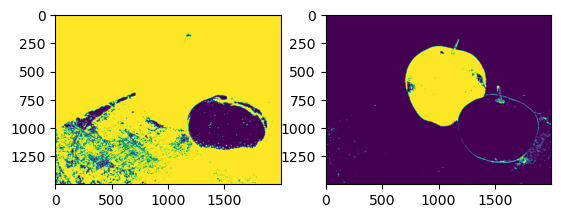

In [178]:
ROC_imgs = []
thresholds = np.linspace( 0 , 1, 100)

for t in range(len((thresholds))): 
    thresh = posteriorApple[0] > thresholds[t]
    ROC_imgs.append(np.float32(thresh*1))
ROC_imgs =  np.asarray(ROC_imgs)
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(ROC_imgs[1])
ax2.imshow(ROC_imgs[50])

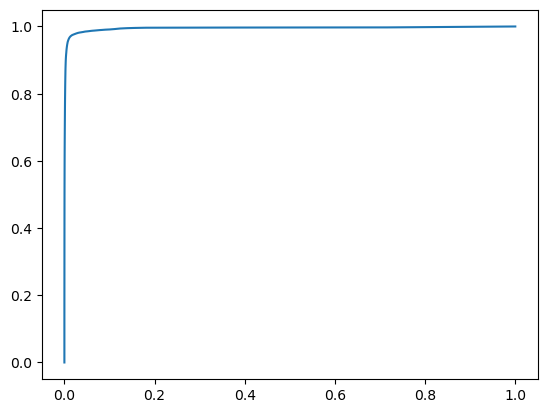

In [179]:
TPR_r = []
FPR_r = []
for t in range(len(thresholds)):
    TP = np.sum(ROC_imgs[t] * gt)
    FP = np.sum(ROC_imgs[t] * (1-gt))
    FN = np.sum((1 -ROC_imgs[t]) * gt)
    TN = np.sum((1- ROC_imgs[t]) * (1-gt))
    TPR =(TP/(TP+FN))
    FPR =(FP/(FP+TN))
    TPR_r = np.append(TPR_r, TPR)
    FPR_r=  np.append(FPR_r, FPR)
plt.plot(FPR_r , TPR_r)

**compare the values of true positive and false positives**

***The ROC plot shows that the rate of true positives converges to 1 as the threshold goes to 100.***

**Question: We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.**

***Ideally, there should be a set to train the immages (TRAINING SET) , one set to validate the accuracy of the model (VALIDATION SET), this set will have information about the ground trouth which will allow us to quantify the accuracy of the model (for example using a ROC curve) , and one set that we want to test. 
The problem in using the same data for training and validation is that we risk of overfitting the model, and since we have only one labeled data set we cannot quantitativelly assess our model.***



***PART D***

**load the training data with the extra immages**

In [180]:
Col_Img = glob.glob("apples/*.jpg") 
ColorImgs2 = [] 
for myFile in Col_Img:
    im = plt.imread(myFile)
    im = im/255
    ColorImgs2.append(im)
Extra_Img = glob.glob("D_apples/*.jpg") 
for myFile in Extra_Img:
    im = plt.imread(myFile)
    im = im/255
    ColorImgs2.append(im)
Extra_Img = glob.glob("D2_apples/*.jpg") 
for myFile in Extra_Img:
    im = plt.imread(myFile)
    im = im/255
    ColorImgs2.append(im)
MaskImage = glob.glob("apples/*.png") 
MaskImgs2 = [] 
for myFile in MaskImage:
    im = plt.imread(myFile) 
    im = im[:,:,1] 
    MaskImgs2.append(im) 
Extramaks =  glob.glob("D_apples/*.png") 
for myFile in Extramaks:
    im = plt.imread(myFile) 
    im = im[:,:,1] 
    MaskImgs2.append(im) 
Extramaks =  glob.glob("D2_apples/*.png") 
for myFile in Extramaks:
    im = plt.imread(myFile) 
    im = im[:,:,1] 
    MaskImgs2.append(im) 

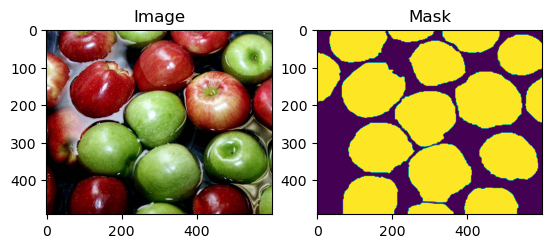

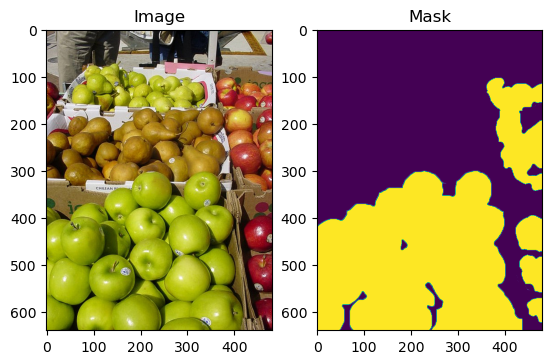

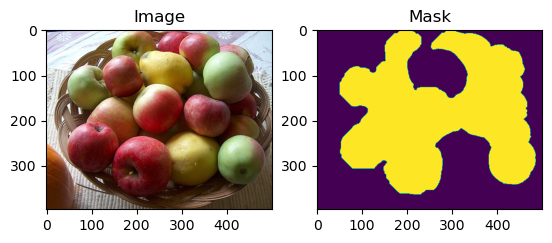

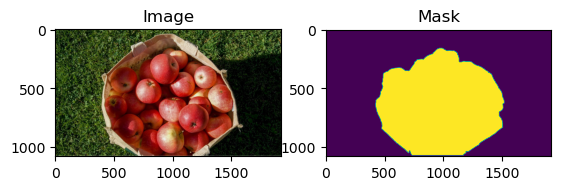

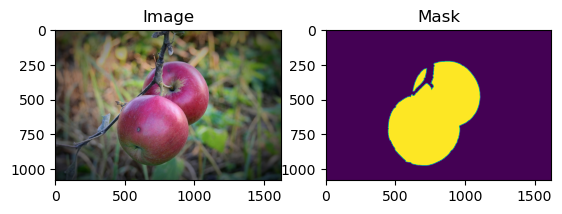

In [181]:
# display the test image and the ground truth mask
for i in range(len(ColorImgs2)):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ColorImgs2[i])
    ax1.set_title('Image')
    ax2.imshow(MaskImgs2[i])
    ax2.set_title('Mask')

In [182]:
nonApple2 = []
Apple2 = []
counterApple2 = 0
counterNonApple2 = 0
for i in range(len(ColorImgs2)):
    for row in range(MaskImgs2[i].shape[0]):
        for col in range(MaskImgs2[i].shape[1]):
            if(MaskImgs2[i][row,col]==0):
                nonApple2.append(ColorImgs2[i][row,col,:])
                counterNonApple2 += 1
            else:
                Apple2.append(ColorImgs2[i][row,col,:])
                counterApple2 += 1
Apples2 = np.array(Apple2).T  
nonApple2 = np.array(nonApple2).T 

In [183]:
#define number of components to estimate
nGaussEst = 3
#fit mixture of Gaussians 
appleMixGaussEst = fitMixGauss(Apples2,nGaussEst);
nonAppleMixGaussEst = fitMixGauss(nonApple2,nGaussEst);

0 iter
1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter
10 iter
11 iter
12 iter
13 iter
14 iter
15 iter
16 iter
17 iter
18 iter
19 iter
20 iter
21 iter
22 iter
23 iter
24 iter
25 iter
26 iter
27 iter
28 iter
29 iter
30 iter
31 iter
32 iter
33 iter
34 iter
35 iter
36 iter
37 iter
38 iter
39 iter
40 iter
41 iter
42 iter
43 iter
44 iter
45 iter
46 iter
47 iter
48 iter
49 iter
0 iter
1 iter
2 iter
3 iter
4 iter
5 iter
6 iter
7 iter
8 iter
9 iter
10 iter
11 iter
12 iter
13 iter
14 iter
15 iter
16 iter
17 iter
18 iter
19 iter
20 iter
21 iter
22 iter
23 iter
24 iter
25 iter
26 iter
27 iter
28 iter
29 iter
30 iter
31 iter
32 iter
33 iter
34 iter
35 iter
36 iter
37 iter
38 iter
39 iter
40 iter
41 iter
42 iter
43 iter
44 iter
45 iter
46 iter
47 iter
48 iter
49 iter


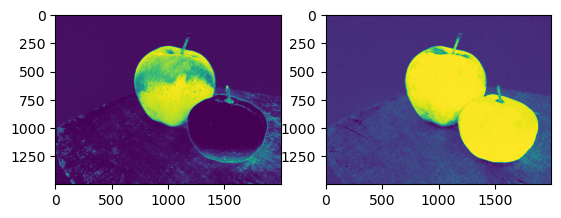

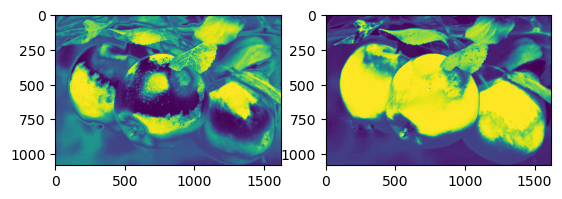

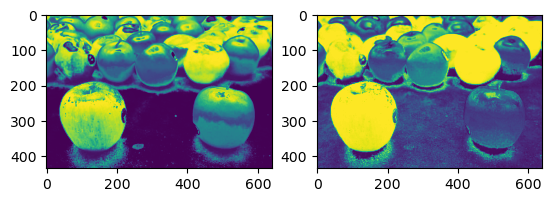

In [184]:
priorApple2 = counterApple2/(counterApple2+counterNonApple2)
# posterior
posteriorApple2 = CalculatePosterior(testImgs,priorApple)
for i in range(len(posteriorApple)):
# test image and the ground truth mask
    f, (ax1 , ax2) = plt.subplots(1,2)
    ax1.imshow(posteriorApple[i])
    ax2.imshow(posteriorApple2[i])
    ax.set_title('Posterior Image for test images')

**The addition of new immages in the training set, increases the occourance of False Positives but it decreases the occourance of false negatives. It can be seen that the colour orange now gets classified as an apple colour in the first picture, but the background of the second picture is darker**

In [185]:
Roc_imgs2 = []
thresholds = np.linspace( 0 , 1, 100)
for t in range(len((thresholds))): 
    thresh = posteriorApple2[0] > thresholds[t]
    Roc_imgs2.append(np.float32(thresh*1))
Roc_imgs2 =  np.asarray(Roc_imgs2)


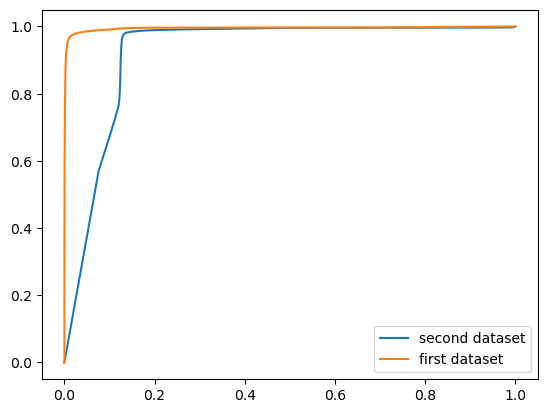

In [186]:
TPR_r2 = []
FPR_r2 = []
for t in range(len(thresholds)):
    TP2 = np.sum(Roc_imgs2[t] * gt)
    FP2 = np.sum(Roc_imgs2[t] * (1-gt))
    FN2 = np.sum((1 -Roc_imgs2[t]) * gt)
    TN2 = np.sum((1- Roc_imgs2[t]) * (1-gt))
    TPR2 =(TP2/(TP2+FN2))
    FPR2 =(FP2/(FP2+TN2))
    TPR_r2 = np.append(TPR_r2, TPR2)
    FPR_r2=  np.append(FPR_r2, FPR2)
plt.plot(FPR_r2 , TPR_r2 , label = 'second dataset')
plt.plot(FPR_r ,TPR_r , label = 'first dataset')
plt.legend()


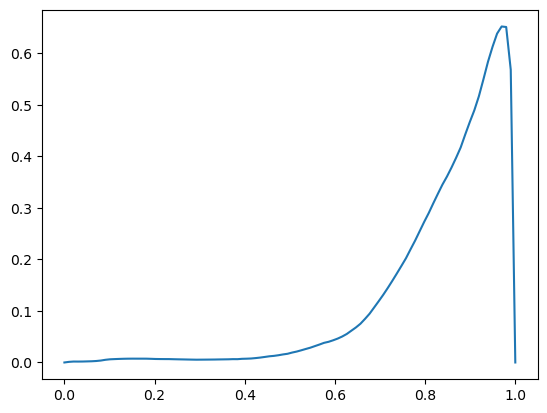

In [187]:
plt.plot(thresholds, (TPR_r2 - TPR_r))

**This plot shows the difference between the positive rate between the two data sets and the number of thresholds used. the error increases for most of the values of the thresholds applied untill 0.9. After that the TPR difference goes back to 0**

**To improve the results we should increase the data set and include more instances of the apples in different scenarios in order to generalize the apple data more**